In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, ResNet50, VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dropout, Input, Flatten, Dense, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from dataclasses import dataclass
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from pathlib import Path
import json
from typing import Iterator
import time
import os
import matplotlib.pyplot as plt



In [ ]:
tf.config.list_physical_devices('GPU')


[]

In [ ]:

@dataclass
class DataIngestionConfig:
    train_path: str
    test_path: str

class DataIngestion:
    def __init__(self, config: DataIngestionConfig) -> None:
        self.config = config

    def data_path(self):
        try:
            train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0.2, shear_range=0.2,
                                               zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2,
                                               validation_split=0.2)

            train_data = train_datagen.flow_from_directory(self.config.train_path,
                                                           target_size=(80, 80), batch_size=8, class_mode='categorical', subset='training')

            validation_data = train_datagen.flow_from_directory(self.config.train_path,
                                                                target_size=(80, 80), batch_size=8, class_mode='categorical', subset='validation')

            test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0.2, shear_range=0.2, zoom_range=0.2,
                                              width_shift_range=0.2, height_shift_range=0.2)

            test_data = test_datagen.flow_from_directory(self.config.test_path,
                                                          target_size=(80, 80), batch_size=8, class_mode='categorical')
        except Exception as e:
            raise e
        return train_data, validation_data, test_data

# Define paths
train_path = "/content/drive/MyDrive/DDD_data/train_data"
test_path = "/content/drive/MyDrive/DDD_data/test_data"

# Create config
config = DataIngestionConfig(train_path, test_path)

# Initialize DataIngestion with the config
data_ingestion = DataIngestion(config)

# Get data paths
train_data, validation_data, test_data = data_ingestion.data_path()




Found 11501 images belonging to 2 classes.
Found 2874 images belonging to 2 classes.
Found 5136 images belonging to 2 classes.


In [ ]:
print(type(train_path))

<class 'str'>


In [ ]:
@dataclass(frozen=True)
class PrepareBaseModelConfig:
    params_learning_rate: float
    model_saved_path: str
    params_batchsize :int

class PrepareBaseModel:
    def __init__(self, config: PrepareBaseModelConfig):
        self.config = config

    def getbasemodel(self,pretrained_model):
        try:
            bmodel = pretrained_model
            hmodel = bmodel.output
            hmodel = Flatten()(hmodel)
            hmodel = Dense(64, activation='relu')(hmodel)
            hmodel = Dropout(0.5)(hmodel)
            hmodel = Dense(2, activation='sigmoid')(hmodel)
            model = Model(inputs=bmodel.input, outputs=hmodel)
            for layer in bmodel.layers:
                layer.trainable = False
        except Exception as e:
            raise e
        return model
    def save_model(self,model):
        try:
            model_saved_path = self.config.model_saved_path
            checkpoint = ModelCheckpoint(model_saved_path, monitor='val_loss', save_best_only=True, verbose=1)
            earlystop = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
            learning_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
            callbacks = [checkpoint, earlystop, learning_rate]
            model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

            hist=model.fit_generator(train_data,steps_per_epoch=train_data.samples//self.config.params_batchsize,
                              validation_data=validation_data,
                              validation_steps=validation_data.samples//self.config.params_batchsize,
                              callbacks=callbacks,
                                epochs=5)
        except Exception as e:
            raise e
        return hist

model_saved_path = "/content/drive/MyDrive/DDD_data/model_new_not_complete_trained.h5"

learning_rate=0.05

batchsize=8
pretrained_model=InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(80, 80, 3)))
base_model_obj=PrepareBaseModel(PrepareBaseModelConfig(params_learning_rate = learning_rate,model_saved_path = model_saved_path,params_batchsize = batchsize))
base_model=base_model_obj.getbasemodel(pretrained_model)
hist=base_model_obj.save_model(base_model)



<ipython-input-16-08a0683160c7>:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_data,steps_per_epoch=train_data.samples//self.config.params_batchsize,


Epoch 1/5
1437/1437 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9166
Epoch 1: val_loss improved from inf to 0.10466, saving model to /content/drive/MyDrive/DDD_data/model_new_not_complete_trained.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1437/1437 [==============================] - 1739s 1s/step - loss: 0.2197 - accuracy: 0.9166 - val_loss: 0.1047 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 2/5
1437/1437 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9353
Epoch 2: val_loss improved from 0.10466 to 0.07573, saving model to /content/drive/MyDrive/DDD_data/model_new_not_complete_trained.h5
1437/1437 [==============================] - 220s 153ms/step - loss: 0.1598 - accuracy: 0.9353 - val_loss: 0.0757 - val_accuracy: 0.9711 - lr: 0.0010
Epoch 3/5
1437/1437 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9449
Epoch 3: val_loss improved from 0.07573 to 0.06642, saving model to /content/drive/MyDrive/DDD_data/model_new_not_complete_trained.h5
1437/1437 [==============================] - 221s 154ms/step - loss: 0.1466 - accuracy: 0.9449 - val_loss: 0.0664 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 4/5
1437/1437 [==============================] - ETA: 0s - loss: 0.1517 - accuracy: 

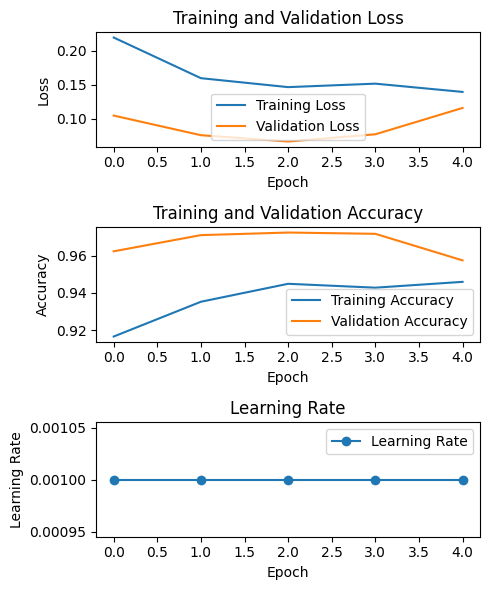

In [ ]:
class EvaluationModel:
    def __init__(self, hist, folder_path: str, model_name: str):
        self.hist = hist
        self.folder_path = folder_path
        self.model_name = model_name

    def save_json(self):
        scores = {
            "Model Name": self.model_name,
            "Testing Loss": self.hist.history['val_loss'],
            "Testing accuracy": self.hist.history['val_accuracy'],
            "Training Loss": self.hist.history['loss'],
            "Training Accuracy": self.hist.history['accuracy']
        }

        # Ensure the directories exist
        os.makedirs(os.path.join(self.folder_path, self.model_name), exist_ok=True)

        json_path = os.path.join(self.folder_path, self.model_name, str(time.time()) + '.json')
        with open(json_path, "w") as f:
            json.dump(scores, f, indent=4)

    def save_score(self):
        # Ensure the directories exist
        os.makedirs(os.path.join(self.folder_path, self.model_name), exist_ok=True)

        fig_path = os.path.join(self.folder_path, self.model_name, str(time.time()) + '.png')

        # Create subplots for each metric
        fig, axs = plt.subplots(3, 1, figsize=(5,6))

        # Plot training and validation loss
        axs[0].plot(self.hist.history['loss'], label='Training Loss')
        axs[0].plot(self.hist.history['val_loss'], label='Validation Loss')
        axs[0].set_title('Training and Validation Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        # Plot training and validation accuracy
        axs[1].plot(self.hist.history['accuracy'], label='Training Accuracy')
        axs[1].plot(self.hist.history['val_accuracy'], label='Validation Accuracy')
        axs[1].set_title('Training and Validation Accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()

        # Plot learning rate
        axs[2].plot(self.hist.history['lr'], label='Learning Rate', marker='o')
        axs[2].set_title('Learning Rate')
        axs[2].set_xlabel('Epoch')
        axs[2].set_ylabel('Learning Rate')
        axs[2].legend()

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Save the plot
        plt.savefig(fig_path)

        # Show the plot (optional)
        # plt.show()

# Define paths and data elsewhere in your code
folder_path="/content/drive/MyDrive/DDD_data"
model_name="Inception"
Evaluation_obj=EvaluationModel(hist,folder_path,model_name)
Evaluation_obj.save_json()
Evaluation_obj.save_score()


Epoch 1/5


<ipython-input-16-08a0683160c7>:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_data,steps_per_epoch=train_data.samples//self.config.params_batchsize,


1437/1437 [==============================] - ETA: 0s - loss: 0.6998 - accuracy: 0.5312
Epoch 1: val_loss improved from inf to 0.69141, saving model to /content/drive/MyDrive/DDD_data/model_new_not_complete_trained.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1437/1437 [==============================] - 433s 298ms/step - loss: 0.6998 - accuracy: 0.5312 - val_loss: 0.6914 - val_accuracy: 0.5299 - lr: 0.0010
Epoch 2/5
1437/1437 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5303
Epoch 2: val_loss improved from 0.69141 to 0.69136, saving model to /content/drive/MyDrive/DDD_data/model_new_not_complete_trained.h5
1437/1437 [==============================] - 429s 298ms/step - loss: 0.6914 - accuracy: 0.5303 - val_loss: 0.6914 - val_accuracy: 0.5299 - lr: 0.0010
Epoch 3/5
1437/1437 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5302
Epoch 3: val_loss improved from 0.69136 to 0.69134, saving model to /content/drive/MyDrive/DDD_data/model_new_not_complete_trained.h5
1437/1437 [==============================] - 428s 298ms/step - loss: 0.6914 - accuracy: 0.5302 - val_loss: 0.6913 - val_accuracy: 0.5303 - lr: 0.0010
Epoch 4/5
1437/1437 [==============================] - ETA: 0s - loss: 0.6914 - accuracy

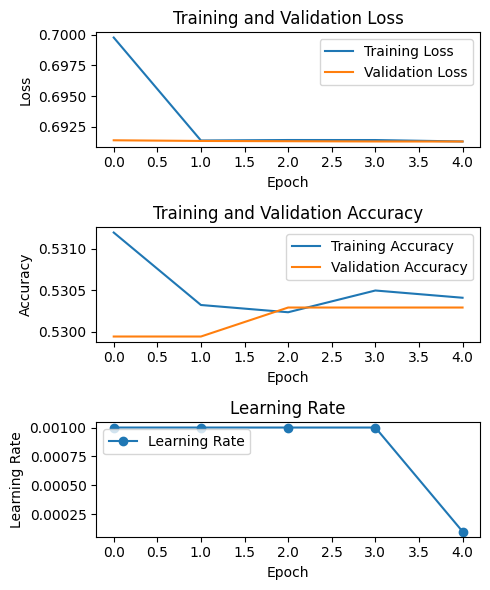

In [ ]:

pretrained_model=ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(80,80,3)))
base_model_obj=PrepareBaseModel(PrepareBaseModelConfig(params_learning_rate = learning_rate,model_saved_path = model_saved_path,params_batchsize = batchsize))
base_model=base_model_obj.getbasemodel(pretrained_model)
res_hist=base_model_obj.save_model(base_model)
folder_path="/content/drive/MyDrive/DDD_data"
model_name="ResNet50"
Evaluation_obj=EvaluationModel(res_hist,folder_path,model_name)
Evaluation_obj.save_json()
Evaluation_obj.save_score()




Epoch 1/5


<ipython-input-16-08a0683160c7>:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_data,steps_per_epoch=train_data.samples//self.config.params_batchsize,


1437/1437 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8415
Epoch 1: val_loss improved from inf to 0.16730, saving model to /content/drive/MyDrive/DDD_data/vgg16_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1437/1437 [==============================] - 1099s 764ms/step - loss: 0.3670 - accuracy: 0.8415 - val_loss: 0.1673 - val_accuracy: 0.9683 - lr: 0.0010
Epoch 2/5
1437/1437 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.8987
Epoch 2: val_loss improved from 0.16730 to 0.13775, saving model to /content/drive/MyDrive/DDD_data/vgg16_model.h5
1437/1437 [==============================] - 1095s 762ms/step - loss: 0.2514 - accuracy: 0.8987 - val_loss: 0.1377 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 3/5
1437/1437 [==============================] - ETA: 0s - loss: 0.2317 - accuracy: 0.9079
Epoch 3: val_loss improved from 0.13775 to 0.12012, saving model to /content/drive/MyDrive/DDD_data/vgg16_model.h5
1437/1437 [==============================] - 1035s 720ms/step - loss: 0.2317 - accuracy: 0.9079 - val_loss: 0.1201 - val_accuracy: 0.9589 - lr: 0.0010
Epoch 4/5
1437/1437 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9153
Epoch 4: val_loss did not 

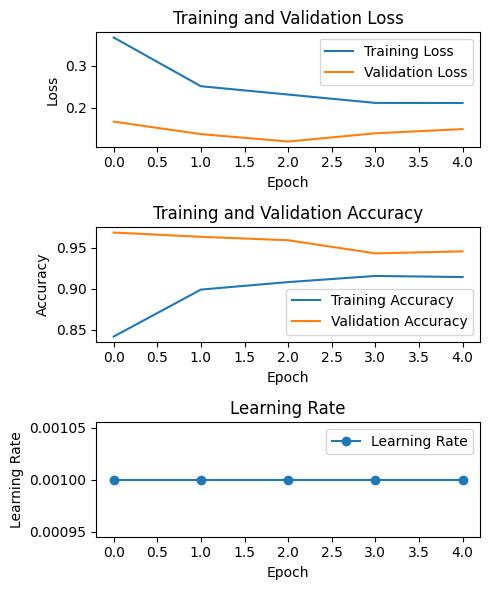

In [ ]:
learning_rate=0.05
batchsize=8
pretrained_model=VGG16(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
model_saved_path = "/content/drive/MyDrive/DDD_data/vgg16_model.h5"
base_model_obj=PrepareBaseModel(PrepareBaseModelConfig(params_learning_rate = learning_rate,model_saved_path = model_saved_path,params_batchsize = batchsize))
base_model=base_model_obj.getbasemodel(pretrained_model)
VGG16_hist=base_model_obj.save_model(base_model)
folder_path="/content/drive/MyDrive/DDD_data"
model_name="VGG16"
Evaluation_obj=EvaluationModel(VGG16_hist,folder_path,model_name)
Evaluation_obj.save_json()
Evaluation_obj.save_score()


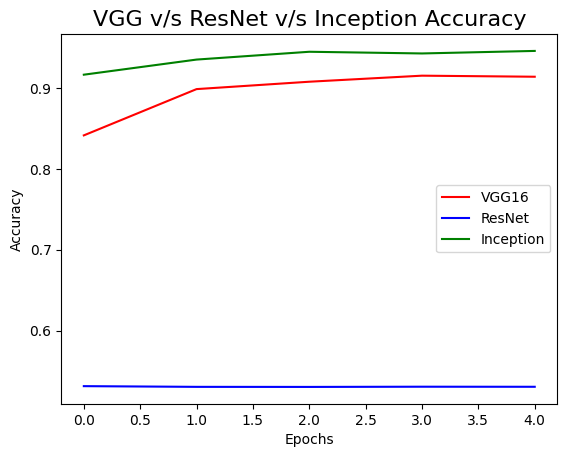

In [ ]:

plt.plot(VGG16_hist.history['accuracy'], color='red', label='VGG16')
plt.plot(res_hist.history['accuracy'], color='blue', label='ResNet')
plt.plot(hist.history['accuracy'], color='green', label='Inception')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("VGG v/s ResNet v/s Inception Accuracy", fontsize=16)
plt.legend()

# Save the plot
plt.savefig('/content/drive/MyDrive/DDD_data/plot.png')

# Show the plot (if needed)
plt.show()

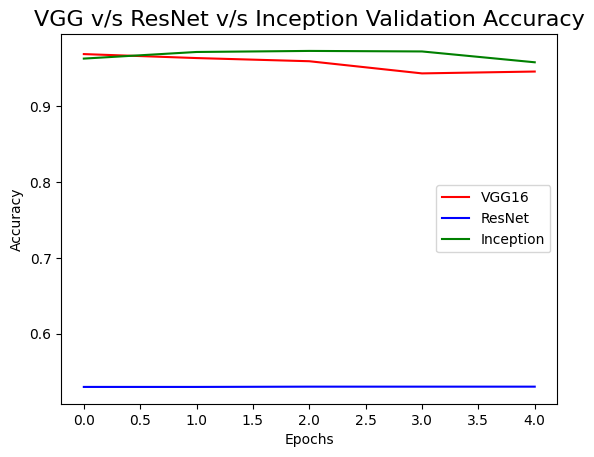

In [ ]:

plt.plot(VGG16_hist.history['val_accuracy'], color='red', label='VGG16')
plt.plot(res_hist.history['val_accuracy'], color='blue', label='ResNet')
plt.plot(hist.history['val_accuracy'], color='green', label='Inception')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("VGG v/s ResNet v/s Inception Validation Accuracy", fontsize=16)
plt.legend()

# Save the plot
plt.savefig('/content/drive/MyDrive/DDD_data/Validation_Accuracy_plot.png')

# Show the plot (if needed)
plt.show()

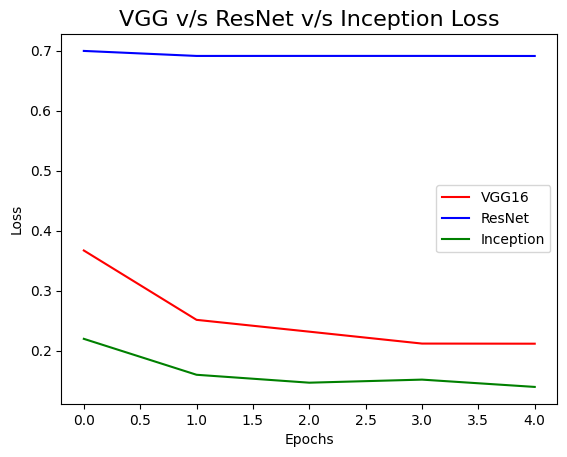

In [ ]:

plt.plot(VGG16_hist.history['loss'], color='red', label='VGG16')
plt.plot(res_hist.history['loss'], color='blue', label='ResNet')
plt.plot(hist.history['loss'], color='green', label='Inception')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VGG v/s ResNet v/s Inception Loss", fontsize=16)
plt.legend()

# Save the plot
plt.savefig('/content/drive/MyDrive/DDD_data/Loss_plot.png')

# Show the plot (if needed)
plt.show()

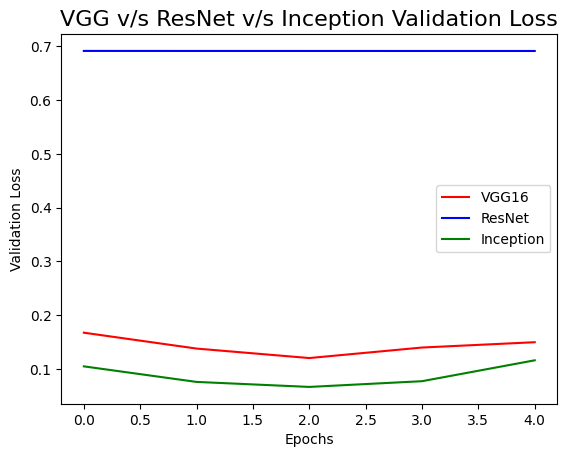

In [ ]:
plt.plot(VGG16_hist.history['val_loss'], color='red', label='VGG16')
plt.plot(res_hist.history['val_loss'], color='blue', label='ResNet')
plt.plot(hist.history['val_loss'], color='green', label='Inception')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("VGG v/s ResNet v/s Inception Validation Loss", fontsize=16)
plt.legend()

# Save the plot
plt.savefig('/content/drive/MyDrive/DDD_data/Validation_Loss_plot.png')

# Show the plot (if needed)
plt.show()